In [497]:
import json
import pandas as pd
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [647]:
#import data
#ive concatenated the fivethirtyeight current and historical congres files together
with open('historical_congress.json') as json_file:  
    data = json.load(json_file)
  

In [505]:
#build a dictionary of congressional years
congress_years = {n:[] for n in range(1770,2021)}

#place reprerasentatives into years they were in congress
for v in data:
    for t in v['terms']:
        if t['type']=='rep':
            tstart= datetime.strptime(t['start'], "%Y-%m-%d")
            tend=datetime.strptime(t['end'], "%Y-%m-%d")
            for r in range (tstart.year,tend.year):
                govtrack_id = v['id']['govtrack']
                
                if govtrack_id not in congress_years[r]:
                    congress_years[r].append(govtrack_id)


1906-1926
1886-1906
1866-1886
1846-1866
1826-1846
1806-1826
1786-1806
1766-1786


In [675]:
#define generations

#NOTE: This analysis considers millennials to be those born after 1986
#PEW defines millennails as 1981-1996, but I believe thoes entering the workforce
#after 2008 have faced fundamentally different life challenges than those who
#entered before the recession


member_lookup={}
gen = {
        'silent':{
            'start':1926,
            'end':1946
        },
        'boomer':{
            'start':1946,
            'end':1965
        },
        'gen-x':{
            'start':1965,
            'end':1986
        },

        'millennial':{
            'start':1986, 
            'end':1996
        },
    }

#create 20 year bands for other generations
for x in range(gen['silent']['start']-20,min(congress_years.keys())-20,-20):
    gen_name= str(x) + '-' + str(x+20)
    gen[gen_name]= {'start':x, 'end':x+20}
    
def getGen(person):
    
    if 'birthday' in person['bio']:
        d1 = datetime.strptime(person['bio']['birthday'], "%Y-%m-%d")
        
        for k,v in gen.iteritems():
            if v['start'] <=d1.year < v['end'] :
                return k
            
    return "other"


#assign generation to each member    
for v in data:
    member_lookup[v['id']['govtrack']]=v
    member_lookup[v['id']['govtrack']]['generation']= getGen(member_lookup[v['id']['govtrack']])


In [663]:
#we now have a dictionary with the year of congress as the key, 
#and the list of representativesas the value

#the following statement gets the name of the first 5 reperasentatives 
#in the 2019 congress
for member in congress_years[2019][0:5]:
    print member_lookup[member]['name']['official_full']
    

Robert B. Aderholt
Justin Amash
Karen Bass
Gus M. Bilirakis
Rob Bishop


In [662]:
#the following statement gets the name of the millennial 
#reperasentatives in the 2019 congress

millennials_2019 = [member 
                    for member in congress_years[2019] 
                    if  member_lookup[member]['generation']=='millennial'
                   ]

for member in millennials_2019:
    print member_lookup[member]['name']['official_full']

Josh Harder
Katie Hill
Abby Finkenauer
Lauren Underwood
Max Rose
Alexandria Ocasio-Cortez


In [676]:
#build a list of rows of the format [govtrack_id, congressional_year, rep_age, generation]

congress_years_age_list_gen=[]
for year,v in congress_years.iteritems():
    congress_years_ages[year]=[]
    for rep in v:
        rep_data = member_lookup[rep] 
        if 'birthday' in rep_data['bio']:
            rep_dob = datetime.strptime(rep_data['bio']['birthday'], "%Y-%m-%d")
            rep_age = year-rep_dob.year
            generation=rep_data['generation']
            
            if rep_age >20:
                congress_years_age_list_gen.append([rep,year,rep_age,generation])
                



In [677]:
#create a dataframe
df = pd.DataFrame(congress_years_age_list_gen,columns=['id','congress','age','generation'])

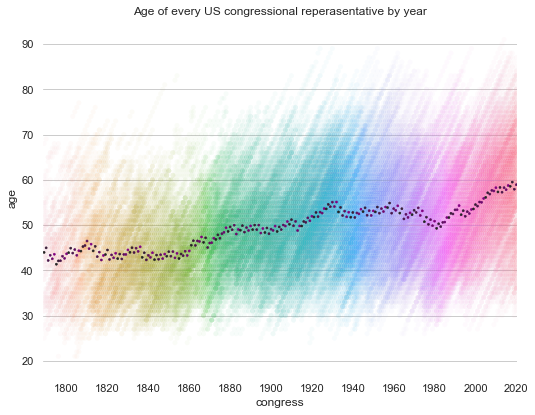

In [669]:
x_axis_tick_distance = 20

f, ax = plt.subplots(figsize=(8.5, 6.5))
sns.despine(f, left=True, bottom=True)

a= sns.stripplot(x="congress", y="age",
                 data=df, 
                 dodge=True,
                 jitter=False,
                 alpha=.04, 
                 zorder=1,
                 ax=ax)


#Show the conditional means
b= sns.pointplot(x="congress", y="age",
              data=df, dodge=.532, 
              join=True,
            palette=sns.dark_palette("purple"),
            scale=.3, 
            ci=None,ax=ax)

ax.set_title('Age of every US congressional reperasentative by year')

#fix x axis tickmarks
for ind, label in enumerate(a.get_xticklabels()):
    if (ind +9) % x_axis_tick_distance == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)


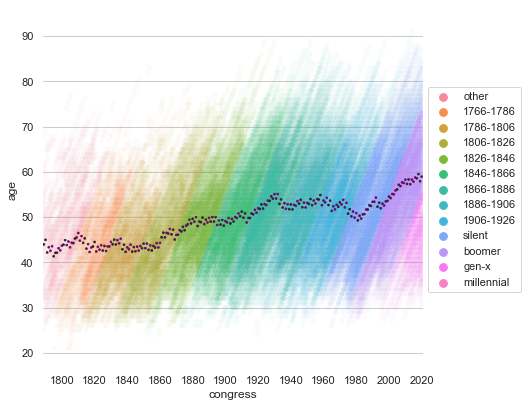

In [817]:
#same plot, but showing the generational bands

x_axis_tick_distance = 20

f, ax = plt.subplots(figsize=(9.5, 6.5))
sns.despine(f, left=True, bottom=True)


a= sns.stripplot(x="congress", y="age",
                 data=df, 
                 dodge=True,
                 hue="generation",
                 jitter=False, 
                 alpha=.04, 
                 zorder=1,
                 ax=ax)


#Show the conditional means
b= sns.pointplot(x="congress", y="age",
                 data=df,
                 dodge=.532,
                 join=False,
                 palette=sns.dark_palette("purple"),
                 scale=.3, 
                 ci=None,ax=ax)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


#fix x axis tickmarks
for ind, label in enumerate(a.get_xticklabels()):
    if (ind +9) % x_axis_tick_distance == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)




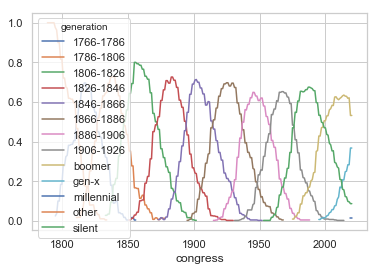

In [707]:
#create a dataframe showing the % of congress held by generation

df_percent_held = df#df.loc[(df['congress']>1950) ]


df_percent_held = pd.pivot_table(df_percent_held, values='id', 
                     index=['congress']
                     ,columns=['generation'],
                     aggfunc=lambda x: len(x.unique()))

df_percent_held["sum"] = df_percent_held.sum(axis=1)
df_percent_held = df_percent_held.loc[:,"1766-1786":"silent"].div(df_percent_held["sum"], axis=0)
df_percent_held.fillna(0)
df_percent_held.plot()

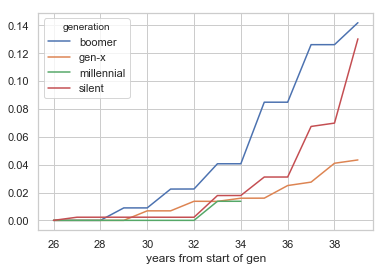

In [736]:
#lets compare the % of representatives held by each generation at the same age

#filter out older genertaions
df_filtered=df_percent_held
to_keep = ['silent','boomer','gen-x','millennial']
to_discard = [g for g in gen.keys() if g not in to_keep]


#optionally, filter the data
df_filtered = df_percent_held.loc[(df_percent_held.index >1950) ]
for d in to_discard:
    df_filtered=df_filtered.drop(d,axis=1)
    
df_filtered=df_filtered.dropna(axis=1,how='all')


new_rows=[]

for x in range(0,len(df_filtered.index)):
    
    for g,d in gen.iteritems():
        if g in df_filtered.columns:
            year = df_filtered.index[x]-gen[g]['start']
            percent = df_filtered.iloc[x][g]
            new_rows.append([g,year,percent])

df6=pd.DataFrame(new_rows,columns=['generation','years from start of gen','percent_of_congress'])
ag_df6 = pd.pivot_table(df6, 
                        values='percent_of_congress', 
                        index=['years from start of gen'],
                        columns=['generation'],
                        aggfunc=lambda x: x.sum())


#filter the data
result2 =ag_df6.loc[(ag_df6.index>25) & (ag_df6.index<40) ]


#plot results
result2.plot()

/Users/ericoetker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ericoetker/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


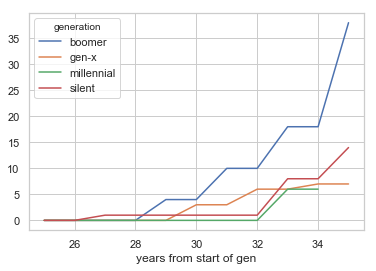

In [816]:
#and the raw number of seats
df_seats= df

#filter the data
df_seats = df.loc[(df['generation']!='other') ]
#df_seats = df.loc[(df['congress']>1950) ]


df_seats['start_year']= df_seats.apply(lambda row: gen[row['generation']]['start'], axis=1)
df_seats['years from start of gen'] = df_seats.apply(lambda row: row.congress-row.start_year, axis=1)


table = pd.pivot_table(df_seats, values='id', index=['years from start of gen'],columns=['generation'],aggfunc=lambda x: len(x.unique()))
result = table.loc[(result.index>=25) &(result.index<40)]

#filter out older genertaions

to_keep = ['silent','boomer','gen-x','millennial']
to_discard = [g for g in gen.keys() if g not in to_keep]

for d in to_discard:
    result=result.drop(d,axis=1)
    


#fill preceeding NaNs
for column in result.columns:
    result.loc[:result[column].first_valid_index()-1,column] = 0




#plot results
result.plot()


In [730]:
#print dictionary for easy exporting to D3
r_dict = result2.to_dict('index')
    
rlist = []
for k,v in r_dict.iteritems():
    rrow={'years from start':k}
    for k2,v2 in v.iteritems():
        rrow[k2]=round(v2*100,1)
    rlist.append(rrow)


rlist = sorted(rlist,key=lambda x: x['years from start'])
for r in rlist:
    print str(r) + ','
    

{'1846-1866': nan, 'boomer': 0.0, 'silent': 0.0, 'millennial': 0.0, '1886-1906': nan, '1866-1886': nan, 'years from start': 26, 'gen-x': 0.0, '1906-1926': nan},
{'1846-1866': nan, 'boomer': 0.0, 'silent': 0.2, 'millennial': 0.0, '1886-1906': nan, '1866-1886': nan, 'years from start': 27, 'gen-x': 0.0, '1906-1926': nan},
{'1846-1866': nan, 'boomer': 0.0, 'silent': 0.2, 'millennial': 0.0, '1886-1906': nan, '1866-1886': nan, 'years from start': 28, 'gen-x': 0.0, '1906-1926': nan},
{'1846-1866': nan, 'boomer': 0.9, 'silent': 0.2, 'millennial': 0.0, '1886-1906': nan, '1866-1886': nan, 'years from start': 29, 'gen-x': 0.0, '1906-1926': nan},
{'1846-1866': nan, 'boomer': 0.9, 'silent': 0.2, 'millennial': 0.0, '1886-1906': nan, '1866-1886': nan, 'years from start': 30, 'gen-x': 0.7, '1906-1926': nan},
{'1846-1866': nan, 'boomer': 2.2, 'silent': 0.2, 'millennial': 0.0, '1886-1906': nan, '1866-1886': nan, 'years from start': 31, 'gen-x': 0.7, '1906-1926': nan},
{'1846-1866': nan, 'boomer': 2.3, 